# Eigenproblems

In this notebook, we will explore the following topics:
* Power iteration
* Rayleigh quotient iteration
* Deflation
* Matrix algebra using numpy
* Application to a real physics problem

## Introduction

A square NxN matrix $A$, has eigenvector $u$ and eigenvalue $\lambda$ that satisfy :

$$(A - \lambda I)u = 0$$

You may be familiar with one method for finding eigenvalues, which is to find the roots of the N-th degree polynomial found by expanding :

$$p(t) = \det{|A - t I|} = 0$$

Finding eigenvalues is closely connected to finding roots of polynomials. Here we will explore some iterative methods for finding both eigenvalues and eigenvectors.

## Power iteration

This is an extremely simple method for finding the largest eigenvector of a matrix, $\lambda^{(0)}$. We start with an initial guess for the eigenvector, $v^{(0)}_0$ and iteratively apply the transformation :
$$v^{(0)}_{i+1} = \frac{Av^{(0)}_i}{|Av^{(0)}_i|}$$

Essentially we multiply the eigenvector guess by the matrix $A$, and then normalise the resulting vector to unit length. Note that here I wil use $\mu$ and $v$ to indicate the estimates of the eigenvalue and eigenvectors, while $\lambda$ and $u$ indicate the true values.

To find the eigenvalue corresponding to each eigenvector estimate, we use the Rayleigh quotient :
$$\mu_{i} = \frac{v^*_i A v_i}{v^*_i v_i}$$


In [1]:
import numpy as np
import scipy.linalg as linalg

# function to update ith eigenvector estimate
def updatePower(A, v_i):
    v_i1 = A@v_i
    return v_i1/linalg.norm(v_i1)

# function to calculate rayleigh quotient from martix and eigenvector estimate
def rayleighQuotient(A, v):
    num = np.conj(v).T @ A @ v
    den = np.conj(v).T @ v
    return num/den

# function to perform power iteration
# returns list of eigenvalues/eigenvectors at each iteration
def powerIteration(A, n_iter):
    vs  = []
    mus = []
    
    v_i  = np.random.random(A.shape[1])
    mu_i = rayleighQuotient(A, v_i)
    vs.append(v_i)
    mus.append(mu_i)
    
    for _ in range(n_iter):
        v_i1  = updatePower(A, v_i)
        mu_i1 = rayleighQuotient(A, v_i1)
        vs.append(v_i1)
        mus.append(mu_i1)
        v_i = v_i1
    
    return np.array(mus), np.array(vs)

To test the routine, we can use the matrix :

$$A = 
\pmatrix{
-2 & -4 & 2 \\
-2 &  1 & 2 \\
4  &  2 & 5}
$$

for which the eigenvalues are $\lambda^{(0)}=6$, $\lambda^{(1)}=-5$, $\lambda^{(2)}=3$. Note that the algorithms discussed here will find _unit_ eigenvectors.  The largest eigenvector is then :

$$\hat{u}^{(0)}=\pmatrix{\frac{1}{\sqrt{293}} \\
\frac{6}{\sqrt{293}} \\
\frac{16}{\sqrt{293}}
}
=
\pmatrix{0.058 \\
0.351 \\
0.935}$$

with numerical values given to 3 decimal places on the RHS.

Next we verify that the solutions found using the power iteration method converge on the expected value for this test case. Note that since the method relies on a randomly generated initial guess for the eigenvector, we set the random seed before calling the method.  This ensures that the same initial guess is used each time we run the Jupyter cell, and will also be the same as used in later tests with a variant on the algorithm.

In [2]:
import math

m = np.array([[-2,-4,2],[-2,1,2],[4,2,5]])

# set seed for repeatability
np.random.seed(2)

# run the algorithm
mus, vs = powerIteration(m, 45)

# print results
print(vs)

[[ 0.4359949   0.02592623  0.54966248]
 [ 0.02715432  0.05562669  0.99808232]
 [ 0.29446291  0.3420972   0.89233463]
 [-0.02651875  0.23621606  0.97133863]
 [ 0.18192338  0.38639215  0.90421513]
 [-0.01604317  0.29088117  0.95662467]
 [ 0.13465607  0.38515724  0.91297406]
 [ 0.00258742  0.31387726  0.94946004]
 [ 0.10900307  0.37703536  0.91976229]
 [ 0.01850985  0.32628256  0.94509104]
 [ 0.09293317  0.36958183  0.92453918]
 [ 0.03037823  0.33400644  0.94208113]
 [ 0.08221657  0.36393579  0.92778832]
 [ 0.03884709  0.33914079  0.9399332 ]
 [ 0.07489323  0.35988914  0.92998431]
 [ 0.04479483  0.34264492  0.93839644]
 [ 0.06984198  0.3570437   0.93147297]
 [ 0.04894619  0.34506091  0.93730317]
 [ 0.06634522  0.35505713  0.9324874 ]
 [ 0.05183634  0.34673326  0.93653032]
 [ 0.06392091  0.35367409  0.93318206]
 [ 0.05384614  0.34789275  0.93598677]
 [ 0.06223897  0.35271238  0.93365962]
 [ 0.05524297  0.34869722  0.93560593]
 [ 0.06107165  0.35204403  0.93398889]
 [ 0.05621349  0.34925558

As can be seen, the series of iterations does converge on the largest eigenvector. Although it is around 40 iterations before all 3 decimal places are in agreement with the analytic solution quoted above.  (ie. corresponding to a maximum error of order $10^{-4}$).

We can go further than this, by plotting the error between each iteration and the analytical solution, as a function of the iteration number. (We choose the error on $v$ as the maximum error on one of its components).

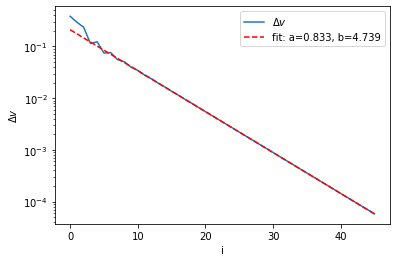

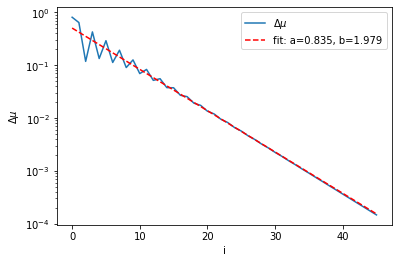

In [4]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# the analytic expectation for error calculations
v_exp  = np.array([1/math.sqrt(293), 6/math.sqrt(293), 16/math.sqrt(293)])
mu_exp = 6

# setup data to store errors
ys = []
zs = []

# loop over iterations
for i in range(len(vs)):
    # get maximum absolute error on elements of eigenvector
    ys.append(np.amax(np.abs(vs[i]-v_exp)))
    # get abs error on eigenvalue
    zs.append(np.abs(mus[i]-mu_exp))

xs = [i for i in range(len(vs))]

# fit a power function to later part of the data
def powerFunc(x, a, b):
    return np.power(a,x)/b

popt_v, pcov_v = curve_fit(powerFunc, xs[20:50], ys[20:50], p0=[0.5, 4])
popt_mu, pcov_mu = curve_fit(powerFunc, xs[20:50], zs[20:50], p0=[0.5, 1])

# plot error on eigenvector v
plt.plot(xs, ys, label=r"$\Delta v$")
plt.plot(xs, powerFunc(xs, *popt_v), 'r-', linestyle="dashed", label='fit: a=%5.3f, b=%5.3f' % tuple(popt_v))
plt.ylabel(r"$\Delta v$")
plt.yscale("log")
plt.xlabel("i")
plt.legend()
plt.show()

# plot error on eigenvalue mu
plt.plot(xs, zs, label=r"$\Delta \mu$")
plt.plot(xs, powerFunc(xs, *popt_mu), 'r-', linestyle="dashed", label='fit: a=%5.3f, b=%5.3f' % tuple(popt_mu))
plt.ylabel(r"$\Delta \mu$")
plt.yscale("log")
plt.xlabel("i")
plt.legend()
plt.show()

The fit results show that the algorithm converges on the result according to 
$$\Delta v \propto 0.83^i$$

It can be shown that the rate of convergence expected depends on the ratio of largest to second largest eigenvalues :
$$\Delta v \propto \Bigg(\frac{\lambda_1}{\lambda_0}\Bigg)^i$$

Which agrees well with our observation, since $\frac{5}{6}= 0.833$.


## Rayleigh quotient iteration

The power iteration method above can be improved (in a sense) by using the eigenvalue estimates $\mu_i$ when computing the next iteration of the eigenvector.  The method is named after the estimate for $\mu_i$, the Rayleigh quotient.

We replace the equation for $v_{i+1}$ with :
$$v_{i+1} = \frac{(A-\mu_i I)^{-1}v_i}{|(A-\mu_i I)^{-1}v_i|}$$

Here we define a new function to generate $v_{i+1}$ from $v_i$, and a function that runs the iteration.  The latter is exactly the same as `powerIteration()`, except that it calls the new method for $v_{i+1}$.

In [5]:
# function to update ith eigenvector estimate
def updateRayleigh(A, v_i, mu_i):
    num = linalg.inv(A - mu_i*np.identity(A.shape[0])) @ v_i
    denom = linalg.norm(num)
    v_i1 = np.true_divide(num, denom)
    return v_i1

# function to perform rayleigh quotient iteration
# returns list of eigenvalues/eigenvectors at each iteration
def rayleighIteration(A, n_iter):
    vs  = []
    mus = []
    
    v_i  = np.random.random(A.shape[1])
    mu_i = rayleighQuotient(A, v_i)
    vs.append(v_i)
    mus.append(mu_i)
    
    for _ in range(n_iter):
        v_i1  = updateRayleigh(A, v_i, mu_i)
        mu_i1 = rayleighQuotient(A, v_i1)
        vs.append(v_i1)
        mus.append(mu_i1)
        v_i = v_i1
    
    return np.array(mus), np.array(vs)

Now we test the convergence in exactly the same way as for power iteration.  Note that we again set the random seed, which ensures the same value for $v_0$ is used as before, so the comparison between the two methods is fair.

[[ 0.4359949   0.02592623  0.54966248]
 [-0.05570252  0.44706243  0.89276672]
 [ 0.10165882  0.30390742  0.94726225]
 [ 0.04351039  0.3668154   0.92927569]
 [ 0.063997    0.34432376  0.93666725]
 [ 0.05637399  0.3527957   0.93400062]
 [ 0.05917888  0.34968063  0.93499803]
 [ 0.05814052  0.35083507  0.93463064]
 [ 0.05852422  0.35040858  0.93476668]
 [ 0.05838233  0.35056632  0.93471641]
 [ 0.05843478  0.350508    0.934735  ]]


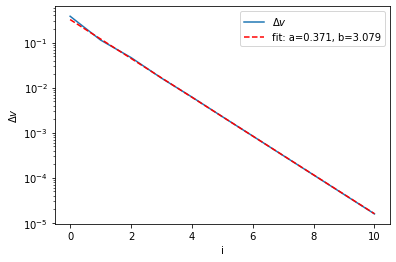

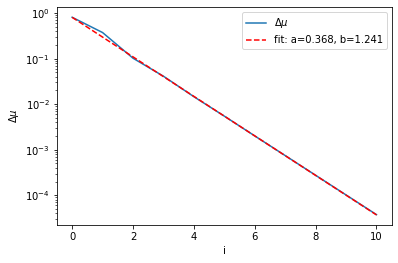

In [6]:
# set seed for repeatability
np.random.seed(2)

# run the algorithm
mus, vs = rayleighIteration(m, 10)

# print results
print(vs)

# setup data for plotting
xs = [i for i in range(len(vs))]
ys = []
zs = []

# loop over iterations
for i in range(len(vs)):
    # get maximum absolute error on elements of eigenvector
    ys.append(np.amax(np.abs(vs[i]-v_exp)))
    # get abs error on eigenvalue
    zs.append(np.abs(mus[i]-6))

# fit a power function to the later part of the data 
popt_v, pcov_v = curve_fit(powerFunc, xs[5:10], ys[5:10], p0=[0.5, 4])
popt_mu, pcov_mu = curve_fit(powerFunc, xs[5:10], zs[5:10], p0=[0.5, 1])

# generate x values for plotting
xs = [i for i in range(len(vs))]

# plot error on eigenvector v
plt.plot(xs, ys, label=r"$\Delta v$")
plt.plot(xs, powerFunc(xs, *popt_v), 'r-', linestyle="dashed", label='fit: a=%5.3f, b=%5.3f' % tuple(popt_v))
plt.ylabel(r"$\Delta v$")
plt.yscale("log")
plt.xlabel("i")
plt.legend()
plt.show()

# plot error on eigenvalue mu
plt.plot(xs, zs, label=r"$\Delta \mu$")
plt.plot(xs, powerFunc(xs, *popt_mu), 'r-', linestyle="dashed", label='fit: a=%5.3f, b=%5.3f' % tuple(popt_mu))
plt.ylabel(r"$\Delta \mu$")
plt.yscale("log")
plt.xlabel("i")
plt.legend()
plt.show()

As you can see, the method converges much faster than power iteration. All 3 decimal places are correct after about 8 iterations.

However, Rayleigh quotient iteration is (a lot) more sensitive to the initial guess for the eigenvector, $b_0$.  Although the method will converge on _an_ eigenpair faster than power iteration, it will not always converge on the same eigenvalue.  In a sense, I have cheated here, by setting the random seed to ensure repeatability - I selected a seed which ensures the algorithm converges on the largest eigenvalue.  You can see what happens if you change the seed to another number; most likely you will see the eigenvalue converges to one of the other eigenvalues.  In practise, if we want to use Rayleigh iteration to find a particular eigenvalue (usually the largest), we must use other methods to detect which eigenvalue the routine is converging on, and adjust the guess accordingly.

In the cell below, you can see the impact of setting a different random seed.  The algorithm converges on a different eigenvector, and also takes longer to converge (since the convergence rate depends on a different ratio of eigenvalues).

In [7]:
# set seed for repeatability
np.random.seed(3)

# run the algorithm
mus, vs = rayleighIteration(m, 30)

# print results
print(vs)

[[ 0.5507979   0.70814782  0.29090474]
 [-0.68970774  0.08867721  0.71863731]
 [ 0.43578373  0.89024675  0.13248871]
 [-0.77542361  0.25435699  0.57794528]
 [ 0.09268148  0.98997015  0.10662671]
 [-0.7523101   0.48072236  0.45048366]
 [-0.22686339  0.96024707  0.16266088]
 [-0.67490041  0.64353603  0.361069  ]
 [-0.39634225  0.89330944  0.21192231]
 [-0.61072543  0.72771565  0.31216083]
 [-0.47193379  0.84842619  0.23969043]
 [-0.57296855  0.76716952  0.28837123]
 [-0.50559674  0.82459399  0.25380442]
 [-0.55332704  0.78549354  0.2771806 ]
 [-0.52096914  0.81277117  0.26075694]
 [-0.54359353  0.79407552  0.27193777]
 [-0.52812265  0.80704341  0.26413519]
 [-0.53886985  0.79812495  0.2694733 ]
 [-0.53148812  0.8042946   0.26576411]
 [-0.53659941  0.80004421  0.26831014]
 [-0.53308075  0.80298085  0.26654582]
 [-0.53551316  0.80095602  0.26775942]
 [-0.53383672  0.80235413  0.26691984]
 [-0.53499466  0.80138972  0.2674981 ]
 [-0.53419612  0.80205544  0.26709846]
 [-0.53474744  0.80159613

## Deflation

Both the above algorithms only find one eigenvalue.  Now we will examine a method that can be used to find all eigenvalues of a problem.

Deflation involves transforming the original matrix into one which has the same eigenvectors, except for the one corresponding to the largest eigenvalue, which becomes zero in the new matrix. ie. if $A$ has eigenvalues $\lambda^{(0..N)}$ and eigenvectors $v^{(0..N)}$ then $B$ has eigenvalues $0, \lambda^{(1..N)}$ and eigenvectors $0,v^{(1..N)}$. To find all the eigenpairs of $A$ we simply iterate on this transformation :
1. Find $\lambda^{(0)}, v^{(0)}$ from $A$
2. Apply deflation transformation to $A$
3. Find $\lambda^{(1)}, v^{(1)}$, and repeat from 2. until all pairs are found

There are a range of transformations we can use in step 2. Hotelling deflation is a simple version that works for symmetric matrices only.  Here the transformation to 'remove' the i-th eigenpair is simply :

$$B = A - \lambda^{(i)} u^{(i)} u^{(i)T}$$

Note the final term includes an outer product.  We encode this in a function below.

In [8]:
# deflate a matrix using Hotelling method
def deflate(A, v, mu):
    return A - (mu ) * np.outer(v, np.conj(v).T) # / np.dot(np.conj(v).T ,v)

For simplicity, we will use this method in conjunction with power iteration as our base method, since it will relialy converge on the largest eigenvalue of the given matrix.  Unlike Rayleigh quotient iteration, which may converge on a different eigenvalue depending on the initial guess.  We will define a new version of the power iteration function, that simply returns the final values found, and also accepts a convergence condition via the `atol` argument.

In [9]:
# function to perform power iteration, with convergence condition
# returns largest eigenvalue + corresponding eigenvector
def powerIteration2(A, n_max, atol):
    vs  = []
    mus = []
    
    v_i  = np.random.random(A.shape[1])
    mu_i = rayleighQuotient(A, v_i)
    
    for _ in range(n_max):
        v_i1  = updatePower(A, v_i)
        mu_i1 = rayleighQuotient(A, v_i1)
        v_i = v_i1
        
        # check for convergence and stop
        if (mu_i1-mu_i) < atol:
            break
        mu_i = mu_i1
    
    return mu_i1, v_i1

Now we define a function that will iterate over the eigenpairs, deflating the matrix each step. 

In [10]:
# eigenproblem solver
# returns list of eigenvalues in descending order
# + list of corresponding eigenvectors
def solveEig(A, n_max, atol):
    mat = A
    mus = []
    vs  = []
    
    # repeat the loop for each of the eigenpairs
    for i in range(A.shape[0]):
        mu, v = powerIteration2(mat, n_max, atol)
        vs.append(v)
        mus.append(mu)
        mat = deflate(mat,v,mu)
    
    return np.array(mus), np.array(vs)

In [11]:
np.random.seed(3)
a = np.array([[1, 2, 1],
             [2, 3, 0],
             [1, 0, 4]])
mus, vs = solveEig(a, 100, 1e-12)
print()
print(mus)
print(vs)


[ 4.71870969  3.68396914 -0.40267883]
[[ 0.48280154  0.56181907  0.67176038]
 [ 0.22609049  0.66111437 -0.71540959]
 [ 0.8460412  -0.49727945 -0.19216513]]


Finally, we should test the values we have obtained are actually solutions to the eigenproblem...

In [12]:
for mu, v in zip(mus, vs):
    print("mu = {0}, v = {1}".format(mu, v))
    print("Close? {0}".format(np.allclose(a@v, mu*np.identity(a.shape[0])@v, atol=1e-9)))

mu = 4.718709690390547, v = [0.48280154 0.56181907 0.67176038]
Close? True
mu = 3.683969139131026, v = [ 0.22609049  0.66111437 -0.71540959]
Close? True
mu = -0.4026788295211902, v = [ 0.8460412  -0.49727945 -0.19216513]
Close? True


Note that the tolerance used here to check the solution is larger than the tolerance specified as a convergence condition.  The convergence condition depends on the difference between $v_i$and $v_{i+1}$,  while the closure depends on the difference between the estimate $v$ and the true eigenvector $u$. 



## A Physical Example

In this section, we illustrate the use of eigenvalue solvers in finding stable solutions of the coupled system of oscillators shown below.

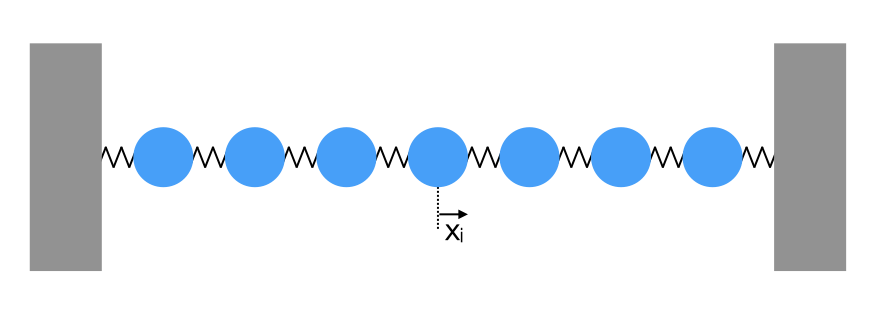

If the displacement of the $i$th mass from its equilibrium position is denoted as $x_i$, the force on the mass is given by the tension in the two springs as :

$$F_i = −k(x_i − x_{i−1}) + k(x_{i+1} − x_i) = −k(2x_i − x_{i−1} − x_{i+1})$$

We can assume that there are normal mode solutions, i.e. solutions of the form $x_i = z_i e^{i\omega t}$ in which all masses oscillate with the same frequency $\omega$ but with unknown phasors $z_i$. Then the above equation becomes :

$$F_i = m\ddot{x}_i = −m\omega^2x_i = −k(2x_i − x_{i−1} − x_{i+1})$$

This is one row of a matrix equation describing the entire system :

$$m\omega^2x_i \left(\begin{array}{c} \vdots \\ \\ x_i \\ \\ \vdots \end{array}\right) = 
\left(\begin{array}{ccccccc} & & & \vdots & & & \\ \cdots & 0 & -1 & 2 & -1 & 0 & \cdots \\ & & & \vdots & & & \end{array}\right)
\left(\begin{array}{c} \vdots \\ x_{i-1} \\ x_i \\ x_{i+1} \\ \vdots \end{array}\right)
$$

This example is a typical eigenvalue problem, in that many of the matrix elements are zero, which can greatly simplify the computational challenge and make even large systems solvable. The matrix is symmetric, which means it is suitable for solving with our eigenproblem solving function above.

In [13]:
m = np.array([[2, -1,  0,  0,  0,  0,  0],
              [-1, 2, -1,  0,  0,  0,  0],
              [0, -1,  2, -1,  0,  0,  0],
              [0,  0, -1,  2, -1,  0,  0],
              [0,  0,  0, -1,  2, -1,  0],
              [0,  0,  0,  0, -1,  2, -1],
              [0,  0,  0,  0,  0, -1,  2]])

mus, vs = linalg.eig(m)

The eigenvalue associated with each mode gives the frequency, while the (complex) eigenvector provides the magnitude and phase of oscillation for each mass. We can plot the displacement of each mass as a function of time for each mode.

Mode       :  0
Eigenvalue :  (3.847759065022569+0j)


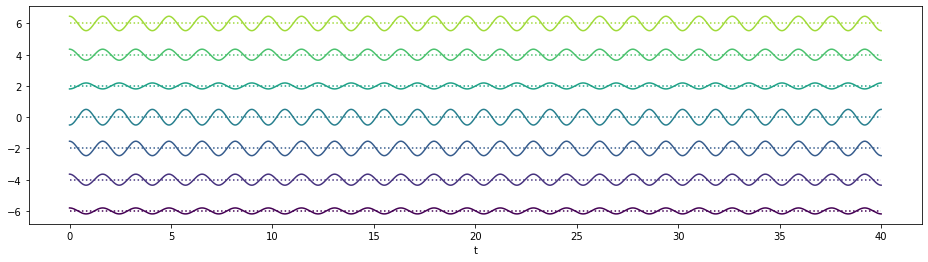

Mode       :  1
Eigenvalue :  (3.4142135623730927+0j)


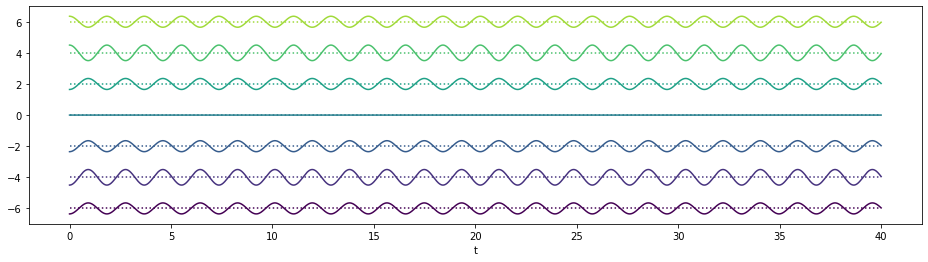

Mode       :  2
Eigenvalue :  (2.765366864730179+0j)


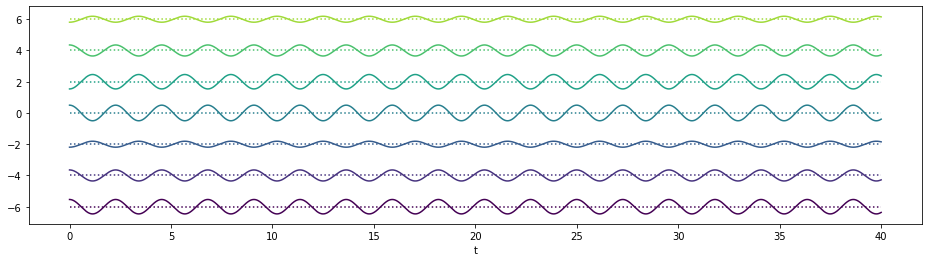

Mode       :  3
Eigenvalue :  (1.9999999999999984+0j)


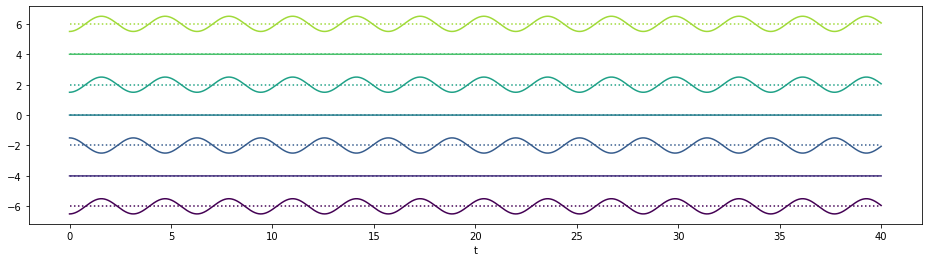

Mode       :  4
Eigenvalue :  (0.15224093497742724+0j)


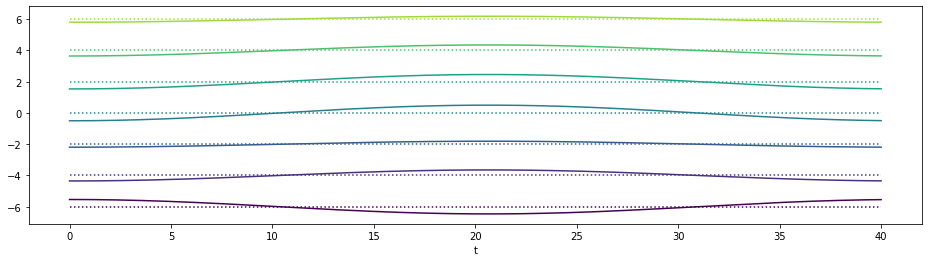

Mode       :  5
Eigenvalue :  (0.585786437626905+0j)


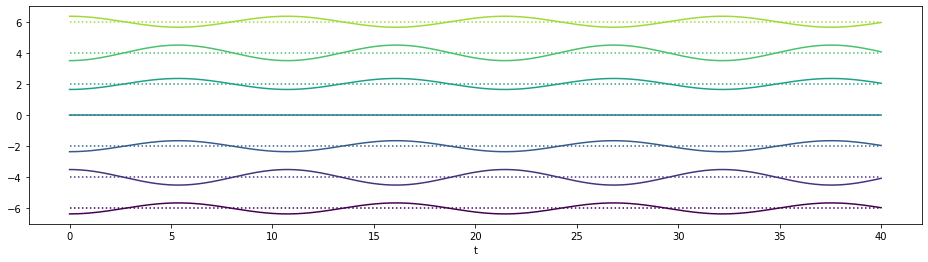

Mode       :  6
Eigenvalue :  (1.2346331352698205+0j)


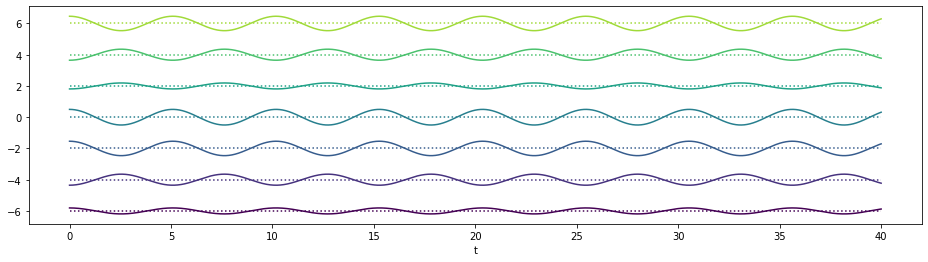

In [19]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

# a function to calculate the (real) displacement from complex phase
def disp(zi, omega, t):
    return np.real(zi * np.exp(1j * omega * t))

# set up some pretty colours for plotting
cm  = plt.cm.viridis
col = [cm(int(x*cm.N/7)) for x in range(7)]

# time period
ts = np.arange(0,40, 0.001)

# loop over eigenmodes
for i in range(7):
    
    print("Mode       : ",i)
    print("Eigenvalue : ", mus[i])

    fig=plt.figure(figsize=(16, 4))

    xs = []
    
    # loop over masses
    for j in range(7):
        
        # get the displacement, and add an offset to separate out each line
        offset = (2*j)-6
        xs     = disp(vs[i][j], mus[i], ts) + offset
        
        # plot displacement
        plt.plot(ts, xs, color=col[j])
        
        # plot central position to guide the eye
        plt.plot([0, 40], [offset, offset], color=col[j], linestyle='dotted') 

    plt.xlabel("t")
    plt.show()
